                                RMSE_LOESS  R2_LOESS  RMSE_Poly   R2_Poly
Temperature (°C)                  2.945620  0.956688  10.380640  0.462100
Pressure (kPa)                   14.190269 -0.005159  14.177066 -0.003289
Temperature x Pressure           13.226914  0.126686  13.379194  0.106461
Material Fusion Metric            7.956039  0.684029   9.783288  0.522225
Material Transformation Metric    2.323389  0.973054   8.177978  0.666155


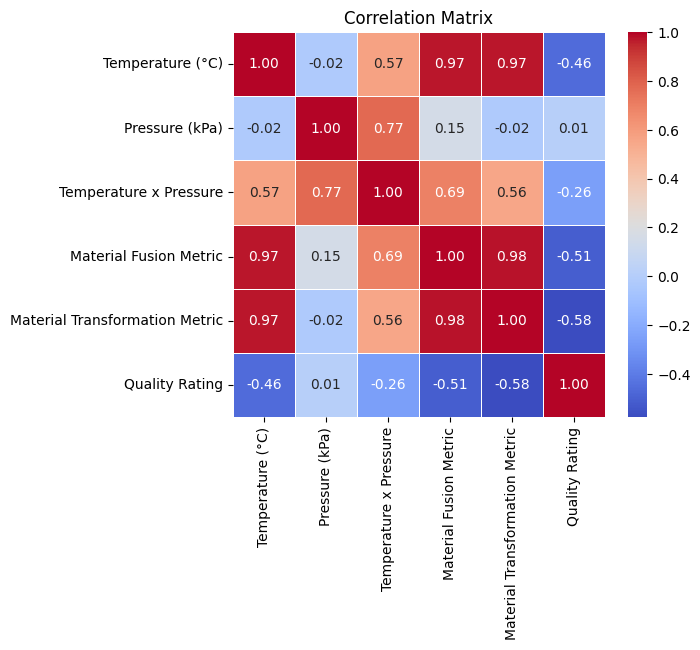

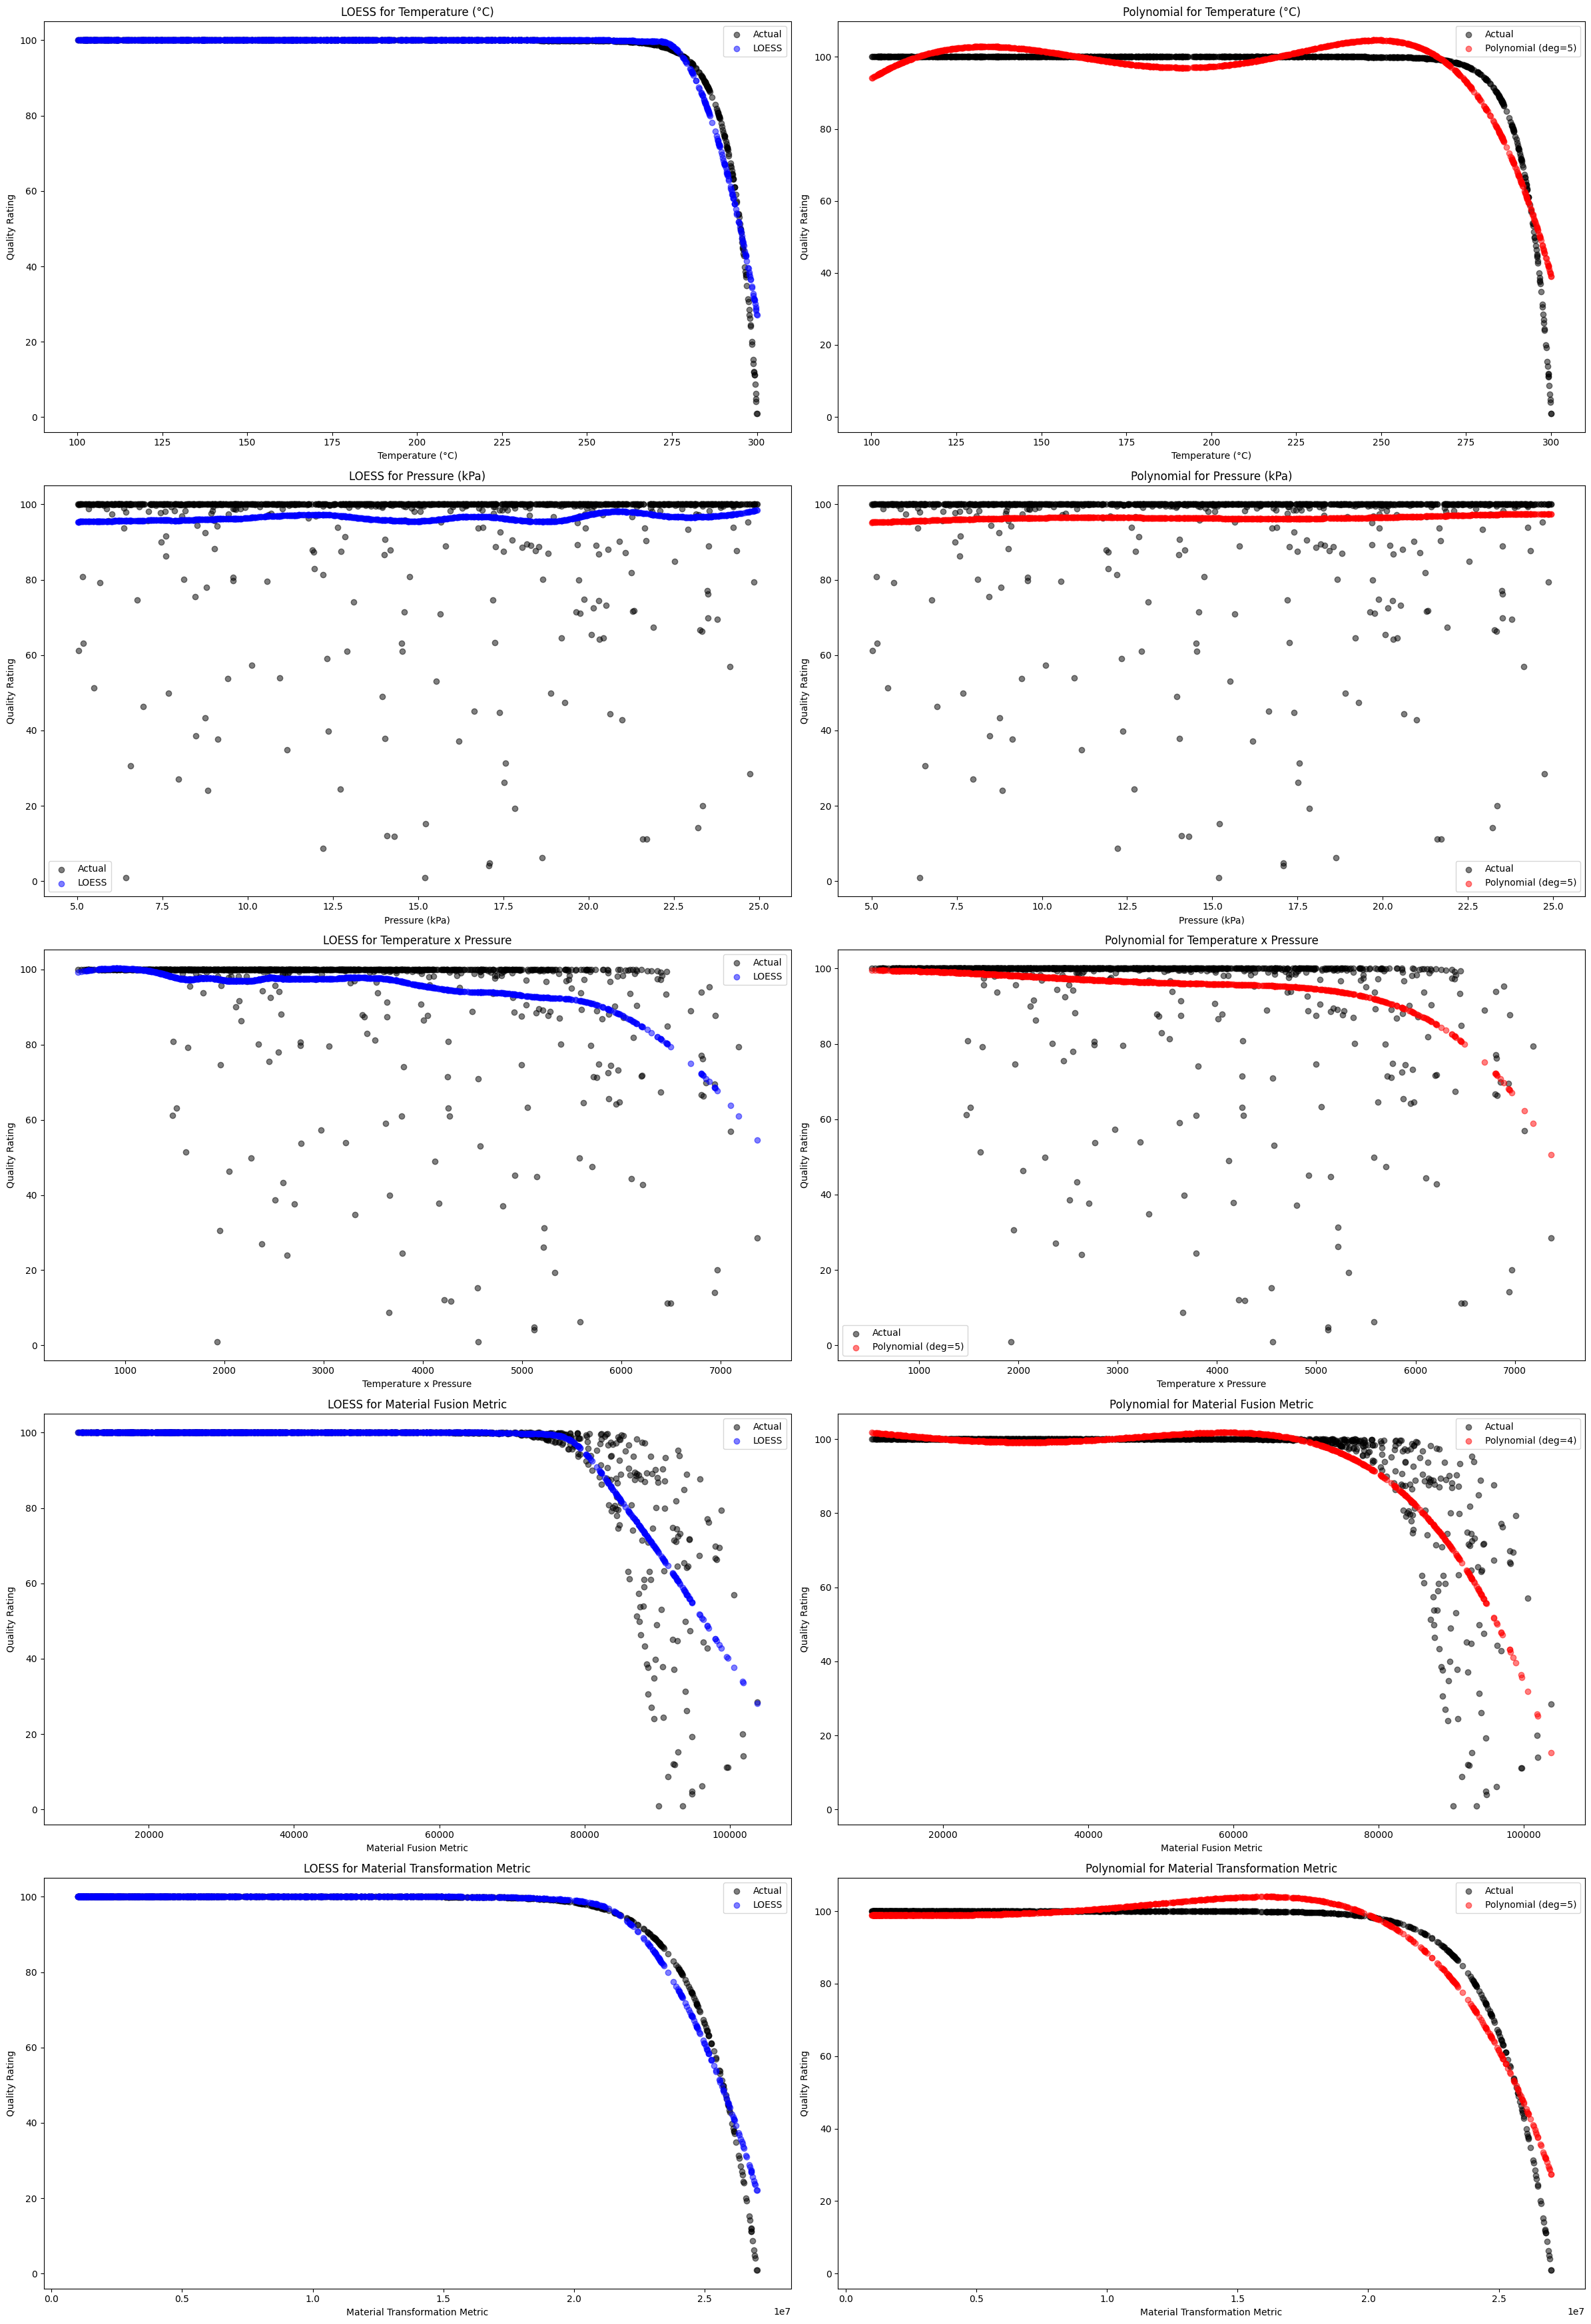

In [ ]:
import numpy as np
import pandas as pd
from pyloess import loess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import sys

def load_manufacturing():
    return pd.read_csv("manufacturing.csv", delimiter=",")

def apply_loess(x_train, y_train, x_test, frac=0.3):
    x_train, y_train, x_test = np.array(x_train), np.array(y_train), np.array(x_test)
    return loess(x_train, y_train, eval_x=x_test, span=frac)

def apply_polynomial_regression(x_train, y_train, x_test, degree=2):
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(x_train.reshape(-1, 1))
    X_poly_test = poly.transform(x_test.reshape(-1, 1))
    model = LinearRegression().fit(X_poly_train, y_train)
    y_pred = model.predict(X_poly_test)
    return y_pred, model

def evaluate_models(x_train, y_train, x_test, y_test):
    results = {}
    for feature in x_train.columns:
        x_train_feat = x_train[feature].values
        x_test_feat = x_test[feature].values

        y_pred_loess = apply_loess(x_train_feat, y_train, x_test_feat)
        rmse_loess = np.sqrt(mean_squared_error(y_test, y_pred_loess))
        r2_loess = r2_score(y_test, y_pred_loess)

        y_pred_poly, poly_model = apply_polynomial_regression(x_train_feat, y_train, x_test_feat, degree=2)
        rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
        r2_poly = r2_score(y_test, y_pred_poly)

        results[feature] = {
            "RMSE_LOESS": rmse_loess,
            "R2_LOESS": r2_loess,
            "RMSE_Poly": rmse_poly,
            "R2_Poly": r2_poly
        }
    return pd.DataFrame(results).T

def get_optimal_degree(x_train, x_test, y_train, y_test):
    degrees = [1, 2, 3, 4, 5]
    errors = []

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(x_train)
        X_poly_test = poly.transform(x_test)

        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)

        y_poly_pred = poly_reg.predict(X_poly_test)
        mse_poly = mean_squared_error(y_test, y_poly_pred)
        errors.append(mse_poly)

    return degrees[np.argmin(errors)]

def plot_correlation_matrix(manufacturing):
    correlation_matrix = pd.DataFrame.corr(manufacturing)
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.savefig("1_correlation_matrix")
    plt.show()

def plot_features(x_train, x_test, y_train, y_test, features_to_plot):
    n_features = len(features_to_plot)
    _, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(24, 35))

    for i, feature in enumerate(features_to_plot):
        x_train_feat = x_train[feature].values
        x_test_feat = x_test[feature].values

        degree = get_optimal_degree(x_train_feat.reshape(-1, 1), x_test_feat.reshape(-1, 1), y_train, y_test)
        y_pred_loess = apply_loess(x_train_feat, y_train, x_test_feat)
        y_pred_poly, _ = apply_polynomial_regression(x_train_feat, y_train, x_test_feat, degree=degree)

        ax_loess = axes[i, 0]
        ax_loess.scatter(x_test_feat, y_test, label="Actual", color="black", alpha=0.5)
        ax_loess.scatter(x_test_feat, y_pred_loess, label="LOESS", color="blue", alpha=0.5)
        ax_loess.set_title(f"LOESS for {feature}")
        ax_loess.set_xlabel(feature)
        ax_loess.set_ylabel("Quality Rating")
        ax_loess.legend()

        ax_poly = axes[i, 1]
        ax_poly.scatter(x_test_feat, y_test, label="Actual", color="black", alpha=0.5)
        ax_poly.scatter(x_test_feat, y_pred_poly, label=f"Polynomial (deg={degree})", color="red", alpha=0.5)
        ax_poly.set_title(f"Polynomial for {feature}")
        ax_poly.set_xlabel(feature)
        ax_poly.set_ylabel("Quality Rating")
        ax_poly.legend()

    plt.savefig("1_loess_vs_polynomial")
    plt.tight_layout()
    plt.show()

manufacturing = load_manufacturing()
X = manufacturing.drop(columns=["Quality Rating"])
y = manufacturing["Quality Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(evaluate_models(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test))
plot_correlation_matrix(manufacturing)
plot_features(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test, features_to_plot=list(X.columns))

    Feature        VIF
0      CRIM   2.025612
1        ZN   3.003111
2     INDUS  13.728656
3      CHAS   1.189900
4        NX  78.474315
5        RM  78.845225
6       AGE  21.522740
7       DIS  14.213186
8       RAD  15.121464
9       TAX  61.352108
10  PTRATIO  78.038582
11        B  21.220594
12    LSTAT  10.136796
             CRIM        ZN     INDUS      CHAS        NX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NX       0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0

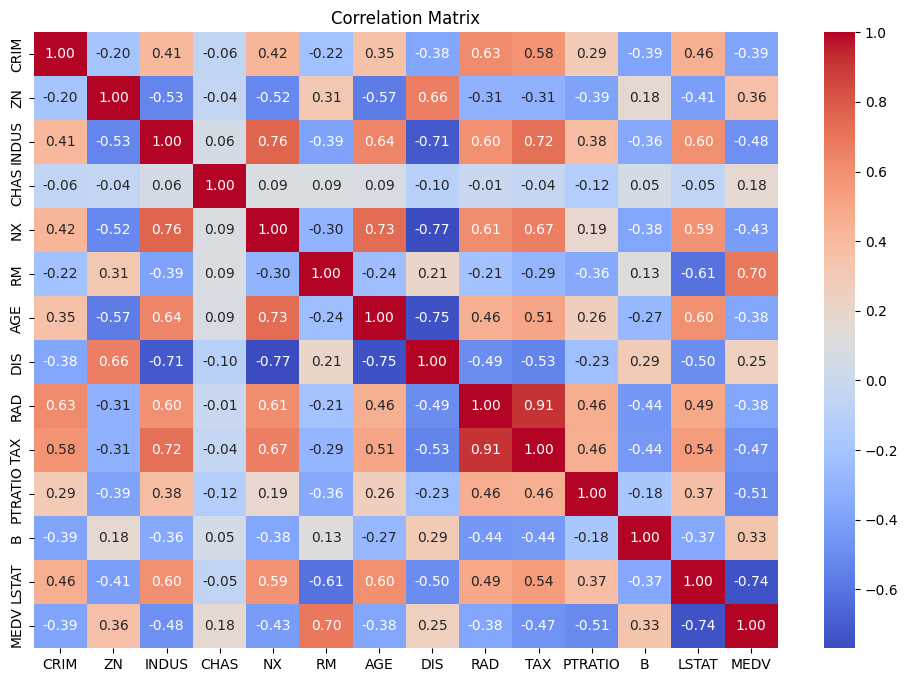

Removing RM (VIF=78.85)
Removing PTRATIO (VIF=61.95)
Removing TAX (VIF=57.74)
Removing NX (VIF=49.73)
Removing B (VIF=14.22)
Removing RAD (p-value=0.8904)
Removing AGE (p-value=0.8669)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     75.81
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           4.96e-92
Time:                        22:08:51   Log-Likelihood:                -1053.8
No. Observations:                 354   AIC:                             2136.
Df Residuals:                     340   BIC:                             2190.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    

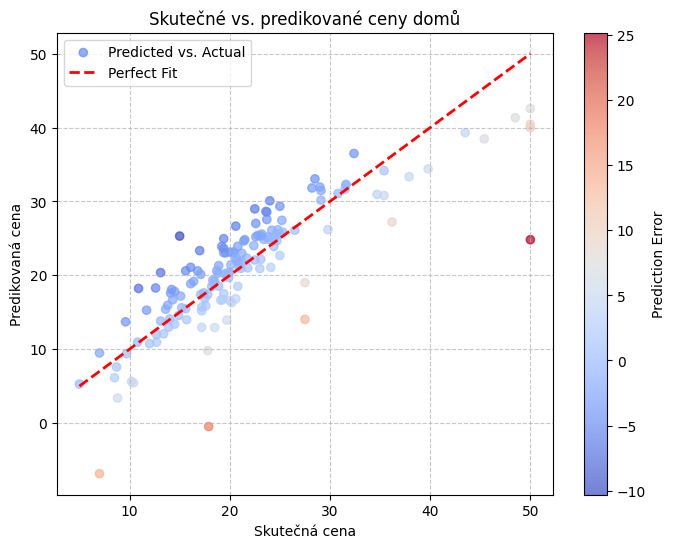

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

def load_house_data():
    return pd.read_csv("house_data.csv", delimiter=",")

def clean_data(df):
    df = df.dropna()
    df = df.drop_duplicates()
    return df

def remove_high_vif_features(df, threshold=10.0):
    while True:
        vif = calculate_vif(df)
        max_vif = vif["VIF"].max()
        if max_vif < threshold:
            break
        feature_to_remove = vif.loc[vif["VIF"].idxmax(), "Feature"]
        print(f"Removing {feature_to_remove} (VIF={max_vif:.2f})")
        df = df.drop(columns=[feature_to_remove])
    return df

def remove_insignificant_features(X, y, p_value_threshold=0.05):
    while True:
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        p_values = model.pvalues[1:]  # Ignorujeme konstantu
        max_p = p_values.max()
        if max_p < p_value_threshold:
            break
        feature_to_remove = p_values.idxmax()
        print(f"Removing {feature_to_remove} (p-value={max_p:.4f})")
        X = X.drop(columns=[feature_to_remove])
    return X

def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.savefig("2_correlation_matrix")
    plt.show()

def normalize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def split_data(df, target_col="MEDV"):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=0.3, random_state=42)

def train_regression_model(X_train, y_train):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model

def evaluate_model(model, X_test, y_test):
    X_test = sm.add_constant(X_test)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred

def plot_predictions(y_test, y_pred):
    errors = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(y_test, y_pred, c=errors, cmap="coolwarm", alpha=0.7, label="Predicted vs. Actual")
    plt.colorbar(sc, label="Prediction Error")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2, linestyle="--", label="Perfect Fit")
    plt.xlabel("Skutečná cena")
    plt.ylabel("Predikovaná cena")
    plt.title("Skutečné vs. predikované ceny domů")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.savefig("2_predictions")
    plt.show()

house_data = clean_data(load_house_data())
X_train, X_test, y_train, y_test = split_data(house_data)

print(calculate_vif(X_train))
print(house_data.corr())
plot_correlation_matrix(house_data)

X_train_scaled, X_test_scaled = normalize_data(X_train, X_test)
X_train = remove_high_vif_features(X_train)
X_train = remove_insignificant_features(X_train, y_train)
model = train_regression_model(X_train_scaled, y_train)
print(model.summary())

rmse, r2, y_pred = evaluate_model(model, X_test_scaled, y_test)
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

plot_predictions(y_test, y_pred)